# Aprendizaje Automático - Grado Estadística y Empresa
## Practica 2: Prediccion de la radiación solar en plantas fotovoltaicas
Integrantes del grupo K:
- Andrés Rubio Lafuente
- Jorge Casamayor Calonge

### Datos y Paquetes

Instalamos y cargamos los paquetes necesarios para realizar la practica.

In [ ]:
 # Para cargar los datos
!pip install feather-format

  Preparing metadata (setup.py) ... done
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2435 sha256=e3fc64477ba19f2bcbb7ee25b18a97e0586abb851dc7268afc8414242cb0fb89
  Stored in directory: /root/.cache/pip/wheels/a6/ff/5d/4f10de26fe5ddef243c97f13c6cf579d7353d659e41a05c3a6
Successfully built feather-format


In [ ]:
# Paquetes para realizar busqueda de hiperparametros con Hyperband
!pip install ray
!pip install -U tensorboardx
!pip install -U ray[tune]
from ray import ray,tune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 787.7 kB/s eta 0:00:00


In [ ]:
# Paquetes basicos
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime  # Serie temporal

# Paquetes de Preproceso
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import r2_score

# Entrenamiento de modelo
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold, RandomizedSearchCV

# No Ensemble
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR, SVR

# Ensemble
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Modelo Final
from joblib import dump, load

Importamos los datos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datos = feather.read_dataframe('/content/drive/MyDrive/Aprendizaje Automatico/Practicas/Practica 2/disp.feather')
datos[:2]

,salida,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,...,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1
0,12384900.0,low,0.0,0.0,0.000000,0.000000,None,low,251.901758,low,...,0.0,high,high,high,260.522389,NaN,low,49.000000,107.181818,73.545455
1,11908500.0,low,0.0,0.0,0.017273,0.139091,blue,medium,271.982095,medium,...,0.0,medium,medium,medium,232.871098,NaN,low,35.545455,72.454545,NaN


Creamos un dataframe que contenga las fechas desde 1994 hasta 2006.

In [ ]:
fecha_inicial = datetime(1994, 1, 5)
fecha_final = datetime(2006, 1, 1)
rango_fechas = pd.date_range(start = fecha_inicial, end = fecha_final)
fechas = pd.DataFrame({'Fecha': rango_fechas})

## EDA

Vemos las dimensiones de los datos.

In [ ]:
datos.shape

(4380, 76)

Vemos los atributos que tenemos.

In [ ]:
datos.columns

Index(['salida', 'apcp_sf1_1', 'apcp_sf2_1', 'apcp_sf3_1', 'apcp_sf4_1',
       'apcp_sf5_1', 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1',
       'dlwrf_s5_1', 'dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1',
       'dswrf_s5_1', 'pres_ms1_1', 'pres_ms2_1', 'pres_ms3_1', 'pres_ms4_1',
       'pres_ms5_1', 'pwat_ea1_1', 'pwat_ea2_1', 'pwat_ea3_1', 'pwat_ea4_1',
       'pwat_ea5_1', 'spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1',
       'spfh_2m5_1', 'tcdc_ea1_1', 'tcdc_ea2_1', 'tcdc_ea3_1', 'tcdc_ea4_1',
       'tcdc_ea5_1', 'tcolc_e1_1', 'tcolc_e2_1', 'tcolc_e3_1', 'tcolc_e4_1',
       'tcolc_e5_1', 'tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1',
       'tmax_2m5_1', 'tmin_2m1_1', 'tmin_2m2_1', 'tmin_2m3_1', 'tmin_2m4_1',
       'tmin_2m5_1', 'tmp_2m_1_1', 'tmp_2m_2_1', 'tmp_2m_3_1', 'tmp_2m_4_1',
       'tmp_2m_5_1', 'tmp_sfc1_1', 'tmp_sfc2_1', 'tmp_sfc3_1', 'tmp_sfc4_1',
       'tmp_sfc5_1', 'ulwrf_s1_1', 'ulwrf_s2_1', 'ulwrf_s3_1', 'ulwrf_s4_1',
   

Vemos el tipo de variables que tenemos (numericas, categoricas, binarias...)

In [ ]:
datos.dtypes

salida         float64
apcp_sf1_1    category
apcp_sf2_1     float64
apcp_sf3_1     float64
apcp_sf4_1     float64
                ...   
uswrf_s1_1     float64
uswrf_s2_1    category
uswrf_s3_1     float64
uswrf_s4_1     float64
uswrf_s5_1     float64
Length: 76, dtype: object

Hacemos un resumen basico de los datos.

In [ ]:
datos.describe()

,salida,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s3_1,dswrf_s1_1,dswrf_s2_1,dswrf_s3_1,pres_ms1_1,...,tmp_sfc5_1,ulwrf_s2_1,ulwrf_s4_1,ulwrf_s5_1,ulwrf_t1_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1
count,4.380000e+03,4380.000000,3504.000000,4380.000000,3767.000000,4380.000000,4380.000000,4380.000000,4380.000000,3854.000000,...,3767.000000,3898.000000,3854.000000,4380.000000,3854.0,4380.000000,482.0,4380.000000,4380.000000,3811.000000
mean,1.687247e+07,0.241592,0.450221,0.251330,0.467992,322.404314,0.048817,157.882233,373.804919,101710.505032,...,290.876778,382.607421,445.544419,437.516798,0.0,263.047956,0.0,75.930656,128.743607,101.531237
std,7.924037e+06,1.062819,1.943508,0.983976,1.713311,58.847925,0.225272,109.684711,156.910276,739.955054,...,10.936917,51.910580,57.538475,58.287767,0.0,38.679321,0.0,30.180077,39.287358,35.126465
min,7.206000e+05,0.000000,0.000000,0.000000,0.000000,167.622281,0.000000,0.000000,19.090909,99314.049006,...,253.174956,217.530941,280.650185,275.581856,0.0,121.743743,0.0,2.363636,4.272727,2.727273
25%,1.137892e+07,0.000000,0.000000,0.000000,0.000000,272.924120,0.000000,50.000000,239.090909,101238.119496,...,282.153395,339.246954,399.840394,390.830446,0.0,244.973457,0.0,53.181818,110.340909,76.909091
50%,1.695705e+07,0.000000,0.000000,0.000000,0.000000,325.027765,0.000000,140.000000,382.227273,101641.318537,...,291.515123,381.992985,444.641027,437.036721,0.0,270.405656,0.0,79.090909,138.454545,107.454545
75%,2.375048e+07,0.033636,0.078182,0.013636,0.045455,377.426168,0.000000,258.250000,518.840909,102136.893821,...,300.705759,431.114186,494.795769,488.092401,0.0,291.828192,0.0,102.113636,156.363636,131.363636
max,3.134790e+07,22.546364,32.670000,24.410000,35.470909,430.194341,2.000000,370.000000,634.727273,104711.001420,...,312.978197,476.145333,571.158569,560.144282,0.0,332.185372,0.0,185.909091,446.272727,313.909091


Vemos si hay valores faltantes para cada variable.

In [ ]:
suma_na = datos.isna().sum()
percent_na = 100 * (suma_na/datos.shape[0])
df_na = pd.DataFrame({'Numero NA':suma_na, 'Porcentaje NA': percent_na})
df_na.sort_values('Porcentaje NA', ascending = False)[:5]

,Numero NA,Porcentaje NA
pwat_ea3_1,4030,92.009132
uswrf_s1_1,3898,88.995434
apcp_sf3_1,876,20.000000
tmp_sfc3_1,657,15.000000
dlwrf_s5_1,657,15.000000


Vemos si hay variables con atributos constantes.

In [ ]:
datos.columns[datos.nunique() == 1]

Index(['pwat_ea3_1', 'spfh_2m3_1', 'tcolc_e3_1', 'tmin_2m2_1', 'tmin_2m4_1',
       'tmp_2m_3_1', 'ulwrf_t1_1', 'uswrf_s1_1'],
      dtype='object')

Realizamos un grafico de la variable respuesta a lo largo del tiempo.

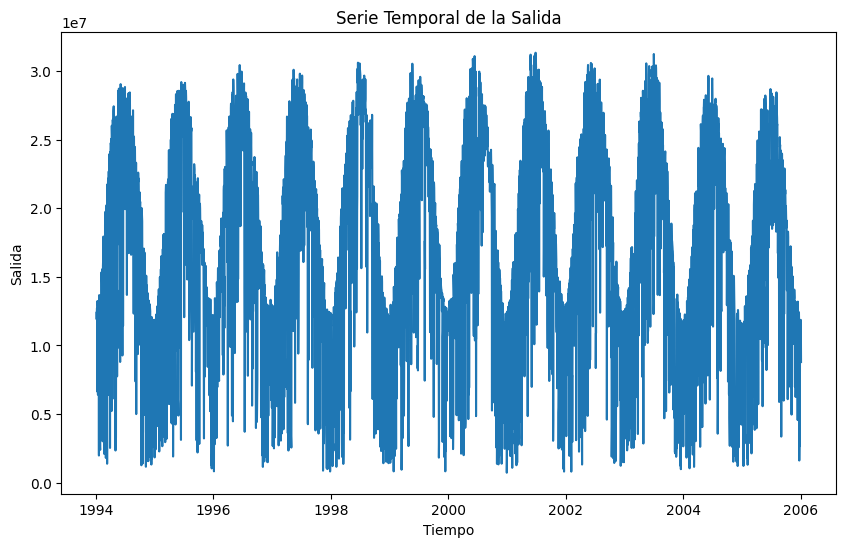

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(fechas, datos['salida'])
plt.xlabel('Tiempo')
plt.ylabel('Salida')
plt.title('Serie Temporal de la Salida')
plt.show()

## Preproceso

Creamos una funcion que elimine las columnas que tengan >= 80% de missing values, pues estas columnas no nos proporcionan información para el modelo.

In [ ]:
datos_na = feather.read_dataframe('/content/drive/MyDrive/Aprendizaje Automatico/Practicas/Practica 2/disp.feather')

def eliminar_na(datos_na):
  b = df_na.shape[0]
  col_datos_na = datos_na.columns
  for i in range(b):
    if df_na.iloc[i,1] >= 80:
      datos_na = datos_na.drop([col_datos_na[i]], axis = 1)
  return(datos_na)

datos = eliminar_na(datos_na)

Dividimos los datos en las variables predictoras X y en la variable respuesta y que es la salida.

In [ ]:
X = datos.drop(['salida'], axis = 1)
y = datos['salida']

Dividimos los datos en entrenamiento y test utilizando un holdout, pero los datos de entrenamiento y los de test no son aleatorios pues tenemos una serie temporal.

Por tanto, los 6 primeros años son de entrenamiento y los 3 restantes son de test.

In [ ]:
tss = TimeSeriesSplit(n_splits = 3)
for i_train, i_test in tss.split(X):
  X_train, X_test = X.iloc[i_train,:], X.iloc[i_test,:]
  y_train, y_test = y[i_train], y[i_test]

Definimos un pipeline para variables numericas y otro para variables categoricas.

El pipeline para variables numericas trata con las variables con atributos constantes, con la imputación de valores faltantes y con el escalado de los datos.

El pipeline para variables categoricas transforma las variables a binarias, trata con las variables con atributos constantes e imputa los valores faltantes.  

In [ ]:
knn_num = KNeighborsRegressor()
knn_cat = KNeighborsClassifier()

num_pipeline = Pipeline([('variance_threshold', VarianceThreshold(0)),
                         ('imputer', IterativeImputer(knn_num)),
                         ('scaler', StandardScaler())])

cat_pipeline = Pipeline([('onehot',OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')),
                         ('variance_threshold', VarianceThreshold(0)),
                         ('imputer', IterativeImputer(knn_cat))])

Vemos que columnas son categoricas y cuales son numericas para aplicar el pipeline correspondiente y entrenamos el modelo con los datos de entrenamiento.

In [ ]:
num_cols = X.select_dtypes(include = ['float64']).columns
cat_cols = X.select_dtypes(include = ['object','category']).columns

preproceso = ColumnTransformer([('num', num_pipeline, num_cols),
                                ('cat', cat_pipeline, cat_cols)])

preproceso.fit(X_train, y_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('variance_threshold',
                                                  VarianceThreshold(threshold=0)),
                                                 ('imputer',
                                                  IterativeImputer(estimator=KNeighborsRegressor())),
                                                 ('scaler', StandardScaler())]),
                                 Index(['apcp_sf2_1', 'apcp_sf3_1', 'apcp_sf4_1', 'apcp_sf5_1', 'dlwrf_s3_1',
       'dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'pres_ms1_1', 'pres_ms2_1',
       'pres_ms3_1'...
                                 Index(['apcp_sf1_1', 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s4_1', 'dlwrf_s5_1',
       'dswrf_s4_1', 'dswrf_s5_1', 'pres_ms5_1', 'pwat_ea1_1', 'pwat_ea5_1',
       'tcdc_ea3_1', 'tcdc_ea4_1', 'tcdc_ea5_1', 'tcolc_e2_1', 'tcolc_e4_1',
       'tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1', 'tmin_2m1_1',
       'tmp_2m_1_1', 'tmp_2m_4_1', 'tmp_sfc2_1', 'tmp_sfc4_1', 'ulwrf_s1_1',
       'ulwrf_s3_1', 'ulwrf_t2_1', 'ulwrf_t3_1', 'ulwrf_t4_1', 'uswrf_s2_1'],
      dtype='object'))])

Ajustamos los hiperparametros del preproceso con un metodo knn.

Ajustamos hiperparametros para el escalado, considerando el StandardScaler, el MinMaxScaler y el MaxAbsScaler para variables numericas.

Ajustamos hiperparametros para la imputacion, considerando el knn para regresion y la media para variables numericas, y el knn para clasificacion y la moda para variables categoricas.

Realizamos validacion interna con holdout y como metrica de evaluacion consideramos el R2.

In [ ]:
param_preproceso = {'preproceso__num__scaler': [StandardScaler(), MinMaxScaler(), MaxAbsScaler()],
                    'preproceso__num__imputer': [IterativeImputer(estimator = knn_num), SimpleImputer(strategy = 'mean')],
                    'preproceso__cat__imputer': [IterativeImputer(estimator = knn_cat), SimpleImputer(strategy = 'most_frequent')]}

pipeline_knn = Pipeline([('preproceso', preproceso),
                         ('knn', KNeighborsRegressor())])

tss = TimeSeriesSplit(n_splits = 3)
grid_search_knn = GridSearchCV(pipeline_knn, param_preproceso, cv = tss, scoring = 'r2')

Realizamos el entrenamiento del modelo con la validacion externa que es un holdout no aleatorio de los datos.

In [ ]:
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preproceso',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('variance_threshold',
                                                                                          VarianceThreshold(threshold=0)),
                                                                                         ('imputer',
                                                                                          IterativeImputer(estimator=KNeighborsRegressor())),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['apcp_sf2_1', 'apc...
      dtype='object'))])),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'preproceso__cat__imputer': [IterativeImputer(estimator=KNeighborsClassifier()),
                                                      SimpleImputer(strategy='most_frequent')],
                         'preproceso__num__imputer': [IterativeImputer(estimator=KNeighborsRegressor()),
                                                      SimpleImputer()],
                         'preproceso__num__scaler': [StandardScaler(),
                                                     MinMaxScaler(),
                                                     MaxAbsScaler()]},
             scoring='r2')

A lo largo de toda la practica, vamos a utilizar tanto validacion interna como validacion externa con holdout sin aleatoriedad.

Una vez entrenado el modelo, obtenemos los mejores valores de los hiperparametros del preproceso.

In [ ]:
mejores_params_knn = grid_search_knn.best_params_
print(mejores_params_knn)

{'preproceso__cat__imputer': IterativeImputer(estimator=KNeighborsClassifier()), 'preproceso__num__imputer': IterativeImputer(estimator=KNeighborsRegressor()), 'preproceso__num__scaler': StandardScaler()}


Obtenemos el mejor score para los datos de entrenamiento.

In [ ]:
score_knn = grid_search_knn.best_score_
print(f'El mejor valor del r2 para los datos de entrenamiento es r2 = {score_knn}')

El mejor valor del r2 para los datos de entrenamiento es r2 = 0.7881002805257419


Determinamos el mejor modelo que sera aquel que incluya los mejores valores de los hiperparametros del preproceso.

Con este modelo obtenemos las predicciones con los datos de test y calculamos el score para datos de test.

In [ ]:
mejor_modelo_knn = grid_search_knn.best_estimator_
y_pred_test_knn = mejor_modelo_knn.predict(X_test)
r2_knn = r2_score(y_test, y_pred_test_knn)
print(f'El mejor valor del r2 para los datos de test es r2 = {r2_knn}')

El mejor valor del r2 para los datos de test es r2 = 0.7500853881453912


Definimos el regresor que incluye los mejores hiperparametros del preproceso y que es el pipeline que utilizamos para toda la practica.

In [ ]:
regresor = Pipeline([('preproceso', preproceso),
                     ('regresor', KNeighborsRegressor())])

## No Ensembles Sin Ajuste HP

El primer caso de la practica que vamos a considerar son los metodos no ensembles sin ajuste de hiperparametros.

Los metodos que se utilizan son: KNN, Arbol, SVM lineal y SVM kernel.

In [ ]:
param_grid = {'regresor': [KNeighborsRegressor(), DecisionTreeRegressor(), SVR(kernel = 'linear'), SVR(kernel = 'rbf')]}

tss = TimeSeriesSplit(n_splits = 3)
grid_search_ne = GridSearchCV(regresor, param_grid, cv = tss, scoring = 'r2')

Entrenamos el modelo.

In [ ]:
grid_search_ne.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preproceso',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('variance_threshold',
                                                                                          VarianceThreshold(threshold=0)),
                                                                                         ('imputer',
                                                                                          IterativeImputer(estimator=KNeighborsRegressor())),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['apcp_sf2_1', 'apc...
       'tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1', 'tmin_2m1_1',
       'tmp_2m_1_1', 'tmp_2m_4_1', 'tmp_sfc2_1', 'tmp_sfc4_1', 'ulwrf_s1_1',
       'ulwrf_s3_1', 'ulwrf_t2_1', 'ulwrf_t3_1', 'ulwrf_t4_1', 'uswrf_s2_1'],
      dtype='object'))])),
                                       ('regresor', KNeighborsRegressor())]),
             param_grid={'regresor': [KNeighborsRegressor(),
                                      DecisionTreeRegressor(),
                                      SVR(kernel='linear'), SVR()]},
             scoring='r2')

Obtenemos el mejor método no ensemble.

In [ ]:
mejores_params_ne = grid_search_ne.best_params_
print(mejores_params_ne)

{'regresor': KNeighborsRegressor()}


Obtenemos el mejor score para los datos de entrenamiento.

In [ ]:
score_ne = grid_search_ne.best_score_
print(f'El mejor valor del r2 para los datos de entrenamiento es r2 = {score_ne}')

El mejor valor del r2 para los datos de entrenamiento es r2 = 0.7881002805257419


Obtenemos el mejor modelo, realizamos las predicciones para los datos de test y obtenemos la metrica de evaluacion del modelo R2 para los datos de test.

In [ ]:
mejor_modelo_ne = grid_search_ne.best_estimator_
y_pred_test_ne = mejor_modelo_ne.predict(X_test)
r2_ne = r2_score(y_test, y_pred_test_ne)
print(f'El mejor valor del r2 para los datos de test es r2 = {r2_ne}')

El mejor valor del r2 para los datos de test es r2 = 0.7500853881453912


## No Ensembles Con Ajuste HP

El segundo caso de la practica que consideramos son los metodos no ensembles con ajuste de hiperparametros.

Son los mismos metodos: KNN, Arbol, SVM lineal y SVM kernel con ajuste de hiperparametros.

Para el KNN ajustamos el hiperparametro numero de vecinos.

Para el arbol ajustamos la maxima profundida del arbol y el numero de instancias necesarias para dividir el arbol.

Para el SVM lineal utilizamos el hiperparametro C, que controla el peso de los datos de entrenamiento que han sido bien clasificados.  

Para el SVM radial ajustamos los hiperparametros C y gamma, el parametro gamma controla la influencia que tienen las instancias de entrenamiento en el modelo.

In [ ]:
param_grid = [{'regresor': [KNeighborsRegressor()],
               'regresor__n_neighbors': [3,5,7,9]},

              {'regresor': [DecisionTreeRegressor()],
               'regresor__max_depth': range(3,11),
               'regresor__min_samples_split': range(5,11)},

              {'regresor': [SVR(kernel = 'linear')],
               'regresor__C': [0.01, 0.10, 1, 10, 100]},

              {'regresor': [SVR(kernel = 'rbf')],
               'regresor__C': [0.01, 0.10, 1, 10, 100],
               'regresor__gamma':np.logspace(-2, 2, 10)}]

tss = TimeSeriesSplit(n_splits = 3)
grid_search_ne_hp = GridSearchCV(regresor, param_grid, cv = tss, scoring = 'r2')

Entrenamiento del modelo.

In [ ]:
grid_search_ne_hp.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preproceso',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('variance_threshold',
                                                                                          VarianceThreshold(threshold=0)),
                                                                                         ('imputer',
                                                                                          IterativeImputer(estimator=KNeighborsRegressor())),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['apcp_sf2_1', 'apc...
                          'regresor__min_samples_split': range(5, 11)},
                         {'regresor': [SVR(kernel='linear')],
                          'regresor__C': [0.01, 0.1, 1, 10, 100]},
                         {'regresor': [SVR()],
                          'regresor__C': [0.01, 0.1, 1, 10, 100],
                          'regresor__gamma': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])}],
             scoring='r2')

Obtenemos el mejor metodo y los mejores hiperparametros.

In [ ]:
mejores_hp_ne_hp = grid_search_ne_hp.best_params_
print(mejores_hp_ne_hp)

{'regresor': KNeighborsRegressor(n_neighbors=9), 'regresor__n_neighbors': 9}


Obtenemos el mejor score para los datos de entrenamiento.

In [ ]:
score_ne_hp = grid_search_ne_hp.best_score_
print(f'El mejor score para el conjunto de entrenamiento es r2 = {score_ne_hp}')

El mejor score para el conjunto de entrenamiento es r2 = 0.8004843819124673


Ajustamos el mejor modelo y calculamos las predicciones y el R2 para los datos de test.

In [ ]:
mejor_modelo_ne_hp = grid_search_ne_hp.best_estimator_
y_pred_test_ne_hp = mejor_modelo_ne_hp.predict(X_test)
r2_ne_hp = r2_score(y_test, y_pred_test_ne_hp)
print(f'El score para el conjunto de test es r2 = {r2_ne_hp}')

El score para el conjunto de test es r2 = 0.7655926046362399


## Ensembles Sin Ajuste HP

El tercer caso de la practica son los metodos ensembles sin ajuste de hiperparametros.

Los metodos ensembles que se consideran son: Random Forest y Gradient Boosting sin ajuste de hiperparametros.

In [ ]:
param_grid= {'regresor': [RandomForestRegressor(random_state = 129), XGBRegressor(random_state = 129)]}

tss = TimeSeriesSplit(n_splits = 3)
random_search_e = RandomizedSearchCV(regresor, param_grid, cv = tss, scoring = 'r2')

Entrenamiento del modelo.

In [ ]:
random_search_e.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('preproceso',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('variance_threshold',
                                                                                                VarianceThreshold(threshold=0)),
                                                                                               ('imputer',
                                                                                                IterativeImputer(estimator=KNeighborsRegressor())),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['apcp_sf2_1...
                                                                  grow_policy=None,
                                                                  importance_type=None,
                                                                  interaction_constraints=None,
                                                                  learning_rate=None,
                                                                  max_bin=None,
                                                                  max_cat_threshold=None,
                                                                  max_cat_to_onehot=None,
                                                                  max_delta_step=None,
                                                                  max_depth=None,
                                                                  max_leaves=None,
                                                                  min_child_weight=None,
                                                                  missing=nan,
                                                                  monotone_constraints=None,
                                                                  multi_strategy=None,
                                                                  n_estimators=None,
                                                                  n_jobs=None,
                                                                  num_parallel_tree=None,
                                                                  random_state=129, ...)]},
                   scoring='r2')

Mejor modelo y mejores hiperparametros.

In [ ]:
mejores_hp_e = random_search_e.best_params_
print(mejores_hp_e)

{'regresor': RandomForestRegressor(random_state=129)}


Mejor score para los datos de entrenamiento.

In [ ]:
score_e = random_search_e.best_score_
print(f'El mejor score para el conjunto de entrenamiento es r2 = {score_e}')

El mejor score para el conjunto de entrenamiento es r2 = 0.8243844734318376


Ajustamos el mejor modelo y calculamos las predicciones y el R2 para los datos de test.

In [ ]:
mejor_modelo_e = random_search_e.best_estimator_
y_pred_test_e = mejor_modelo_e.predict(X_test)
r2_e = r2_score(y_test, y_pred_test_e)
print(f'El score para el conjunto de test es r2 = {r2_e}')

El score para el conjunto de test es r2 = 0.815364621422875


## Ensembles Con Ajuste HP

Consideramos ahora el Random Forest y Gradient Boosting con ajuste de hiperparametros.

Para el Random Forest ajustamos el numero de arboles que se utilizan en la creacion del modelo y el porcentaje de variables que se utilizan para realizar una division del arbol.

Para el Gradient Boosting ajustamos el numero de arboles que se utilizan para la construccion del modelo y la tasa de aprendizaje que controla la contribucion de cada arbol al modelo.

Definimos el espacio de busqueda de hiperparametros en el que tenemos que fijar una semilla para no obtener resultados diferentes cada vez que ejecutemos el codigo, pues el Random Search escoge configuraciones aleatorias de hiperparametros.

In [ ]:
param_grid = [{'regresor': [RandomForestRegressor(random_state = 129)],
               'regresor__n_estimators': [10, 50, 100, 200],
               'regresor__max_features': [0.01, 0.1, 0.2, 0.3, 0.5]},

              {'regresor': [XGBRegressor(random_state = 129)],
               'regresor__n_estimators': [10, 50, 100, 200],
               'regresor__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5]}]

tss = TimeSeriesSplit(n_splits = 3)
random_search_e_hp =  RandomizedSearchCV(regresor, param_grid, cv = tss, scoring = 'r2', random_state = 129)

Entrenamiento del modelo.

In [ ]:
random_search_e_hp.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('preproceso',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('variance_threshold',
                                                                                                VarianceThreshold(threshold=0)),
                                                                                               ('imputer',
                                                                                                IterativeImputer(estimator=KNeighborsRegressor())),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['apcp_sf2_1...
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=129, ...)],
                                         'regresor__learning_rate': [0.01, 0.1,
                                                                     0.2, 0.3,
                                                                     0.5],
                                         'regresor__n_estimators': [10, 50, 100,
                                                                    200]}],
                   random_state=129, scoring='r2')

Obtenemos los mejores valores de los hiperparametros.

In [ ]:
mejores_hp_e_hp = random_search_e_hp.best_params_
print(mejores_hp_e_hp)

{'regresor__n_estimators': 200, 'regresor__max_features': 0.1, 'regresor': RandomForestRegressor(max_features=0.1, n_estimators=200, random_state=129)}


Obtenemos el mejor score para los datos de entrenamiento.

In [ ]:
score_e_hp = random_search_e_hp.best_score_
print(f'El mejor score para el conjunto de entrenamiento es r2 = {score_e_hp}')

El mejor score para el conjunto de entrenamiento es r2 = 0.830908070329094


Ajustamos el mejor modelo, calculamos las predicciones y el score para datos de test.

In [ ]:
mejor_modelo_e_hp = random_search_e_hp.best_estimator_
y_pred_test_e_hp = mejor_modelo_e_hp.predict(X_test)
r2_e_hp = r2_score(y_test, y_pred_test_e_hp)
print(f'El score para el conjunto de test es r2 = {r2_e_hp}')

El score para el conjunto de test es r2 = 0.8236089415210992


## Modelo Final

Obtenemos que el mejor modelo lo proporciona el Random Forest con  200 arboles y max_features = 0.1.

Por tanto, entrenamos dicho modelo con todos los datos disponibles y lo guardamos en un fichero joblib.

In [ ]:
X_trans = pd.DataFrame(mejor_modelo_e_hp[:-1].fit_transform(X))
mejor_modelo_e_hp[-1].fit(X_trans, y)
dump(mejor_modelo_e_hp, '/content/drive/MyDrive/Aprendizaje Automatico/Practicas/Practica 2/mejor_modelo_e_hp_joblib')

['/content/drive/MyDrive/Aprendizaje Automatico/Practicas/Practica 2/mejor_modelo_e_hp_joblib']

Mostramos el modelo final.

In [ ]:
modelo_final = load('/content/drive/MyDrive/Aprendizaje Automatico/Practicas/Practica 2/mejor_modelo_e_hp_joblib')
print(modelo_final)

Pipeline(steps=[('preproceso',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('variance_threshold',
                                                                   VarianceThreshold(threshold=0)),
                                                                  ('imputer',
                                                                   IterativeImputer(estimator=KNeighborsRegressor())),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['apcp_sf2_1', 'apcp_sf3_1', 'apcp_sf4_1', 'apcp_sf5_1', 'dlwrf_s3_1',
       'dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'pres_ms...
       'tcdc_ea3_1', 'tcdc_ea4_1', 'tcdc_ea5_1', 'tcolc_e2_1', 'tcolc_e4_1',
       'tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1', 'tmin_2m1_1',
       'tmp_2m_1_1'

## Predicciones

Cargamos los datos que vamos a utilizar para predecir el modelo final, que contienen los 3 ultimos años de datos disponibles.

In [ ]:
datos_pred = feather.read_dataframe('/content/drive/MyDrive/Aprendizaje Automatico/Practicas/Practica 2/compet.feather')
datos_pred[:2]

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,...,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1
0,low,0.0,0.0,0.0,0.0,blue,low,275.618003,medium,blue,...,0.0,medium,high,high,262.813816,NaN,low,48.000000,105.727273,70.545455
1,low,0.0,NaN,0.0,0.0,blue,low,258.974701,low,red,...,0.0,medium,medium,high,255.737294,NaN,low,49.909091,109.181818,NaN


Obtenemos las predicciones para los datos utilizando el modelo final que es un Random Forest con 200 arboles y max_features = 0.1.

In [ ]:
pred_fin = modelo_final.predict(datos_pred)
pred_fin = pd.DataFrame(pred_fin)

Por ultimo, guardamos las predicciones finales en un archivo csv.

In [ ]:
ruta_csv = '/content/drive/MyDrive/Aprendizaje Automatico/Practicas/Practica 2/predicciones.csv'
pred_fin.to_csv(ruta_csv, index = False)

## Investigación Adicional: Hyperband

En la ultima parte de la practica se nos pide realizar una investigacion adicional sobre algun otro metodo de ajuste de hiperparametros, en este caso el hyperband.

Para aplicar la tecnica de busqueda de hiperparametros hyperband, necesitamos aplicar primero un preproceso a los datos.

In [ ]:
X_train_2 =  pd.DataFrame(preproceso.transform(X_train))
X_test_2 =  pd.DataFrame(preproceso.transform(X_test))

Inicializamos el hyperband.

In [ ]:
ray.init
ray.tune.tune

<module 'ray.tune.tune' from '/usr/local/lib/python3.10/dist-packages/ray/tune/tune.py'>

Definimos la funcion de perdida, que en nuestro caso es la metrica de evaluacion R2.

In [ ]:
def loss_function(model, X, y):
  y_pred = model.predict(X)
  return r2_score(y, y_pred)

Definimos el modelo Random Forest asi como los hiperparametros que se van a ajustar, que son el numero de arboles y el % de variables necesarias para dividir el arbol.

Entrenamos el modelo con los datos de entrenamiento y aplicamos la funcion de perdida a los datos de test.

Dado que la funcion de perdida es la metrica R2, en nuestro caso nos interesa maximizar dicha metrica.

In [ ]:
def train_regresor(config):
  model = RandomForestRegressor(n_estimators = config["n_estimators"],
                                max_features = config["max_features"],
                                n_jobs = -1)
  model.fit(X_train_2, y_train)
  loss = loss_function(model, X_test_2, y_test)
  metrics = {"loss": loss}
  ray.train.report(metrics)

Definimos el espacio de busqueda de hiperparametros, donde hemos decidido replicar los valores de los hiperparametros de los metodos ensembles para comprobar que metodo de ajuste de hiperparametros es mejor, si el Random Search o el Hyperband.

Aplicamos el hyperband para que busque los mejores hiperparametros.

In [ ]:
search_space= {"n_estimators": tune.grid_search([10, 50, 100, 200]),
               "max_features": tune.grid_search([0.01, 0.1, 0.2, 0.3, 0.5])}

analysis = tune.run(train_regresor,
                    config = search_space,
                    metric = "loss",
                    mode = "max",
                    scheduler = tune.schedulers.HyperBandScheduler())

2023-12-14 17:06:59,790	INFO worker.py:1673 -- Started a local Ray instance.
2023-12-14 17:07:03,728	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-12-14 17:07:03,733	INFO tune.py:595 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+-----------------------------------------------------------------------+
| Configuration for experiment     train_regresor_2023-12-14_17-07-03   |
+-----------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                |
| Scheduler                        HyperBandScheduler                   |
| Number of trials                 20                                   |
+-----------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_regresor_2023-12-14_17-07-03
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/train_regresor_2023-12-14_17-07-03`

Trial status: 16 PENDING
Current time: 2023-12-14 17:07:11. Total running time: 1s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------+
| Trial name                   status       n_estimators     max_feature

Obtenemos los mejores hiperparametros del metodo Random Forest asi como el valor de su metrica R2 obtenida.

In [ ]:
best_trial = analysis.get_best_trial(metric = "loss", mode = "max")
best_config = best_trial.config
best_loss = best_trial.last_result["loss"]
print(f"El mejor modelo encontrado tiene un R2 = {round(best_loss, 4)} y usa {best_config['n_estimators']} árboles, y {best_config['max_features']} max_features")

El mejor modelo encontrado tiene un R2 = 0.8237 y usa 200 árboles, y 0.1 max_features
